# XPCS&XSVS Pipeline for Single-(Gi)-SAXS Run
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [2]:
from chxanalys.chx_packages import *
%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})
#%reset -f  #for clean up things in the memory

## Control Runs Here

In [3]:
scat_geometry = 'ang_saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
#scat_geometry = 'gi_saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
#scat_geometry = 'saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)

force_compress = False #True   #force to compress data 
bin_frame = True  #generally make bin_frame as False

para_compress = True    #parallel compress
run_fit_form = False    #run fit form factor 
run_waterfall = True #False   #run waterfall analysis
run_t_ROI_Inten = True  #run  ROI intensity as a function of time
run_one_time = True  #run  one-time
#run_fit_g2 = True       #run  fit one-time, the default function is "stretched exponential"
fit_g2_func = 'stretched'
run_two_time = True #False #True #True #False    #run  two-time
run_four_time = True #False   #run  four-time
run_xsvs= True #False         #run visibility analysis
att_pdf_report = True    #attach the pdf report to CHX olog
qth_interest = 0#3      #the intested single qth             
use_sqnorm = False    #if True, use sq to normalize intensity
use_imgsum_norm=True  #if True use imgsum to normalize intensity for one-time calculatoin
pdf_version='_1'     #for pdf report name
if scat_geometry == 'gi_saxs':run_xsvs= False 
if scat_geometry == 'ang_saxs':
    run_xsvs= False;run_waterfall=False;run_two_time=False;run_four_time=False;run_t_ROI_Inten=False; 
     
    

In [4]:
taus=None;g2=None;tausb=None;g2b=None;g12b=None;taus4=None;g4=None;times_xsv=None;contrast_factorL=None;  

## Make a directory for saving results

In [5]:
CYCLE = '2016_3'
username = getpass.getuser()
#username = "colosqui"   #provide the username to force the results to save in that username folder
data_dir0 = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'
os.makedirs(data_dir0, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir0)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/yuzhang/Results/


## Load Metadata & Image Data



### Change this line to give a uid

In [6]:
uid = '96c5dd'  #count : 1 ['8a5346'] (scan num: 9948) (Measurement: XPCS series alpha=0.16,.1s &4.9s 100 frames )
uid = '89297ae8'  #for xpcs
#uid = 'a1e0fb'  #C60/graphene1 4th scan 18k frames, 10Hz, incidence angle 0.2 deg 

uid= '97fb2c' #Measurement: S2 flow 750hz 5k xv2=85.57  -80ul/hr-Hydrophobic
uid= '99aaa04f' #for flow test
#uid = 'a1e0fb'  #C60/graphene1 4th scan 18k frames, 10Hz, incidence angle 0.2 deg 


In [7]:
#start_time, stop_time = '2016-11-30  17:41:00', '2016-11-30  17:46:00'  
#sids, uids = find_uids(start_time, stop_time)

In [8]:
data_dir = os.path.join(data_dir0, '%s/'%uid)
os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)
uidstr = 'uid=%s'%uid

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/yuzhang/Results/99aaa04f/


# Don't Change these lines below here

* get metadata

In [9]:
md = get_meta_data( uid )

* get data

In [10]:
imgs = load_data( uid, md['detector'], reverse= True  )
md.update( imgs.md );Nimg = len(imgs);
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )

hdf5 path = /XF11ID/data/2016/12/03/fc90f137-fbf4-4a3a-a58a_3837_master.h5
The data are: Sliced and/or processed FixedEigerImages. Original repr:
    <Frames>
    Length: 1000 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint16


In [11]:
print_dict( md,  ['suid', 'number of images', 'uid', 'scan_id', 'start_time', 'stop_time', 'sample', 'Measurement',
                  'acquire period', 'exposure time',  
         'det_distanc', 'beam_center_x', 'beam_center_y', ] )

suid--> 99aaa04f
number of images--> 1000
uid--> 99aaa04f-a6af-4ca0-9e5b-1c9e2704d6be
scan_id--> 11068
start_time--> 2016-12-03 18:51:37
stop_time--> 2016-12-03 18:52:12
sample--> S3
Measurement--> S3/U2 40ul/hr dxv2=0.1 1k frames 750Hz
acquire period--> 0.001339999958872795
exposure time--> 0.0013299999991431832
det_distanc--> 4.89
beam_center_x--> 1443.0
beam_center_y--> 816.0


## Overwrite Some Metadata if Wrong Input

In [12]:
inc_x0 = None
inc_y0=  None

dpix, lambda_, Ldet,  exposuretime, timeperframe, center = check_lost_metadata(
    md, Nimg, inc_x0 = inc_x0, inc_y0=   inc_y0, pixelsize = 7.5*10*(-5) )

setup_pargs=dict(uid=uidstr, dpix= dpix, Ldet=Ldet, lambda_= lambda_, exposuretime=exposuretime,
        timeperframe=timeperframe, center=center, path= data_dir)

print_dict( setup_pargs )

timeperframe--> 0.00134
dpix--> 0.0750000035623
lambda_--> 1.28481
center--> [816, 1443]
Ldet--> 4890.0
exposuretime--> 0.0013299999991431832
path--> /XF11ID/analysis/2016_3/yuzhang/Results/99aaa04f/
uid--> uid=99aaa04f


## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change the blow line to give mask filename

In [13]:
if scat_geometry == 'gi_saxs':
    mask_path = '/XF11ID/analysis/2016_3/masks/'
    #mask_name =  'Nov16_4M-GiSAXS_mask.npy'
    mask_name =  'Octo_11_mask.npy'
    
elif scat_geometry == 'saxs' or scat_geometry =='ang_saxs':
    mask_path = '/XF11ID/analysis/2016_3/masks/'
    mask_name = 'Nov28_4M_SAXS_mask.npy'  #for saxs test
   
    mask_path = '/XF11ID/analysis/2016_3/masks/'
    mask_name = 'Dec3_4M_SAXS_mask.npy'  #for flow test, uid = 99aaa04f

<IPython.core.display.Javascript object>


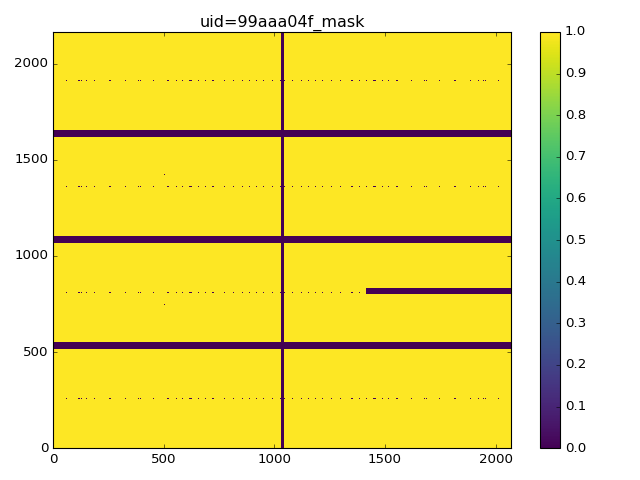

In [14]:
mask = load_mask(mask_path, mask_name, plot_ =  False, image_name = uidstr + '_mask', reverse=True ) 
mask *= pixel_mask
mask[:,2069] =0 # False  #Concluded from the previous results
show_img(mask,image_name = uidstr + '_mask', save=True, path=data_dir)
mask_load=mask.copy()
imgsa = apply_mask( imgs, mask )

# Check several frames average  intensity

In [15]:
img_choice_N = 3
img_samp_index = random.sample( range(len(imgs)), img_choice_N) 
avg_img =  get_avg_img( imgsa, img_samp_index, plot_ = False, uid =uidstr)
if avg_img.max() == 0:
    print('There are no photons recorded for this uid: %s'%uid)
    print('The data analysis should be terminated! Please try another uid.')

<IPython.core.display.Javascript object>


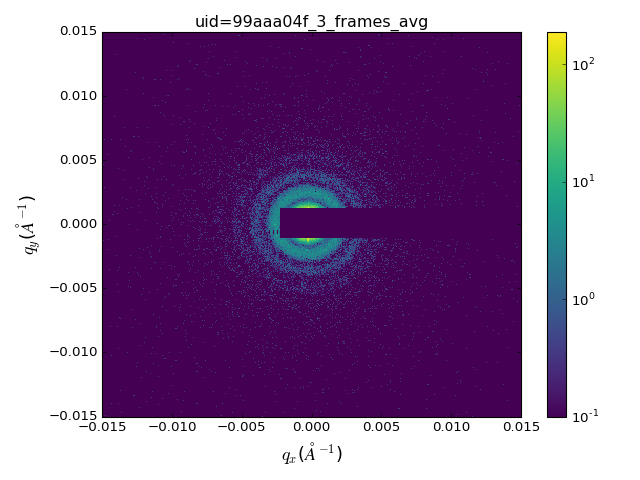

In [16]:
if scat_geometry == 'gi_saxs':
    show_img( avg_img,  vmin=.1, vmax=np.max(avg_img*.1), logs=True,
 image_name= uidstr + '_%s_frames_avg'%img_choice_N,  save=True, path=data_dir) 
else:    
    show_saxs_qmap( avg_img, setup_pargs, width=200, show_pixel = False,
       vmin=.1, vmax= np.max(avg_img), logs=True, image_name= uidstr + '_%s_frames_avg'%img_choice_N )

## Compress Data
* Generate a compressed data with filename
* Replace old mask with a new mask with removed hot pixels
* Do average image
* Do each image sum
* Find badframe_list for where image sum above bad_pixel_threshold
* Check shutter open frame to get good time series


In [17]:
compress=True
photon_occ = len( np.where(avg_img)[0] ) / ( imgsa[0].size)
#compress =  photon_occ < .4  #if the photon ocupation < 0.5, do compress
print ("The non-zeros photon occupation is %s."%( photon_occ))
print("Will " + 'Always ' + ['NOT', 'DO'][compress]  + " apply compress process.")

The non-zeros photon occupation is 0.002961863169322891.
Will Always DO apply compress process.


In [18]:
good_start = 5  #5  #make the good_start at least 0

In [19]:
bin_frame =  False # True  #generally make bin_frame as False

In [20]:
if bin_frame:
    bin_frame_number=4
    timeperframe = acquisition_period * bin_frame_number
else:
    bin_frame_number =1

Get each frame intensity:  36%|███▌      | 356/1000 [00:00<00:00, 3557.24it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_99aaa04f-a6af-4ca0-9e5b-1c9e2704d6be.cmp.


Averaging 985 images:  16%|█▋        | 163/1000 [00:00<00:00, 1629.71it/s]

Bad frame list length is: 15


Averaging 985 images: 100%|██████████| 1000/1000 [00:00<00:00, 2090.34it/s]


The good_start frame number is: 42 
uid=99aaa04f_fra_42_1000


<IPython.core.display.Javascript object>


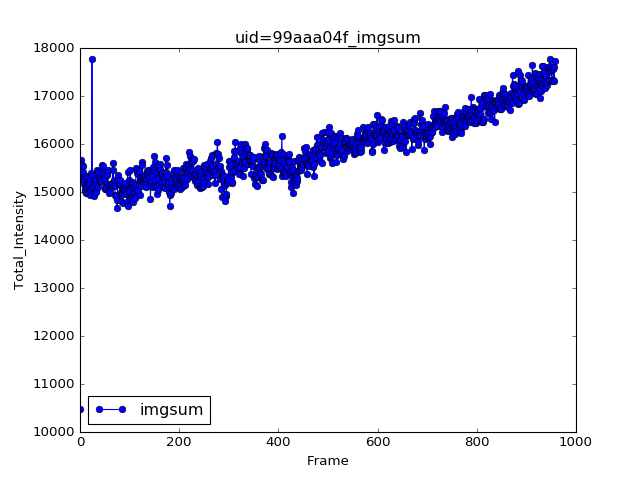

Total time: 0.02 min


In [21]:
t0= time.time()
if bin_frame_number==1:
    filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%md['uid']
else:
    filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s_bined--%s.cmp'%(md['uid'],bin_frame_number) 
mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
         force_compress= force_compress,  para_compress= para_compress,  bad_pixel_threshold= 1e14,
                        bins=bin_frame_number, num_sub= 100, num_max_para_process= 500  )
min_inten = 10    
good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )    
print ('The good_start frame number is: %s '%good_start)
FD = Multifile(filename, good_start, len(imgs)//bin_frame_number)
#FD = Multifile(filename, good_start, 100)
uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
print( uid_ )
plot1D( y = imgsum[ np.array( [i for i in np.arange(good_start, len(imgsum)) if i not in bad_frame_list])],
       title =uidstr + '_imgsum', xlabel='Frame', ylabel='Total_Intensity', legend='imgsum'   )
Nimg = Nimg/bin_frame_number

run_time(t0)

In [24]:
#%system   free && sync && echo 3 > /proc/sys/vm/drop_caches && free

## Get bad frame list by a polynominal fit

/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


<IPython.core.display.Javascript object>


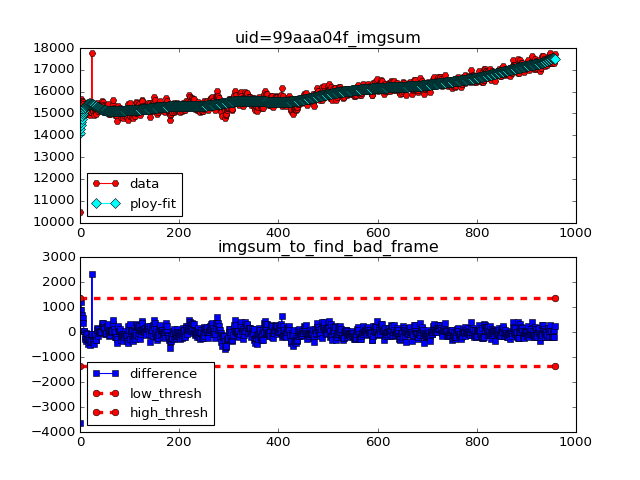

here
The bad frame list length is: 44


In [23]:
bad_frame_list =  get_bad_frame_list( imgsum, fit=True, plot=True,polyfit_order = 30, 
                        scale= 5.5,  good_start = good_start, uid= uidstr, path=data_dir)

print( 'The bad frame list length is: %s'%len(bad_frame_list) )

#### For beamline to find the bad pixels

In [25]:
#bp = find_bad_pixels( FD, bad_frame_list, md['uid'] )
#bp.to_csv('/XF11ID/analysis/Commissioning/eiger4M_badpixel.csv', mode='a'  )

### Creat new mask by masking the bad pixels and get new avg_img

In [26]:
imgsum_y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])]
imgsum_x = np.arange( len( imgsum_y))
save_lists(  [imgsum_x, imgsum_y], label=['Frame', 'Total_Intensity'],
           filename=uidstr + '_img_sum_t', path= data_dir  )


### Plot time~ total intensity of each frame

<IPython.core.display.Javascript object>


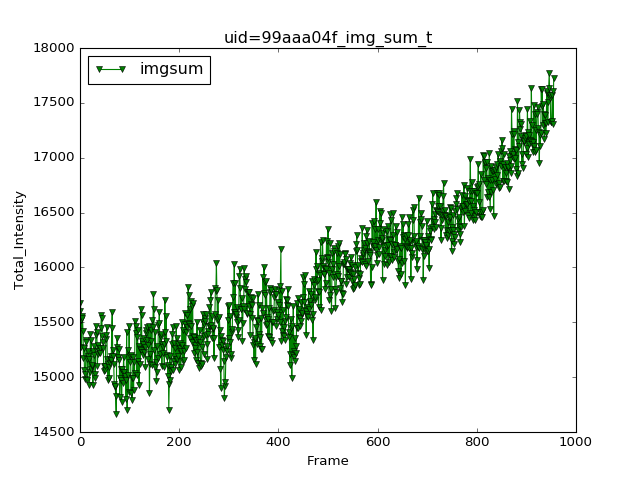

In [27]:
plot1D( y = imgsum_y, title = uidstr + '_img_sum_t', xlabel='Frame',
       ylabel='Total_Intensity', legend='imgsum', save=True, path=data_dir)

### Plot intensity average image

<IPython.core.display.Javascript object>


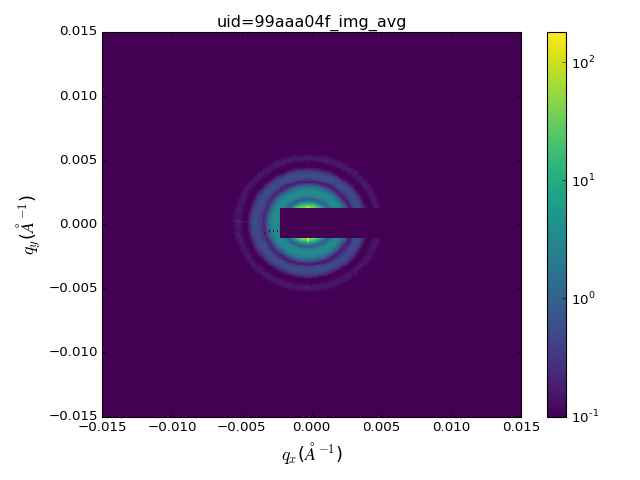

In [28]:
if scat_geometry =='saxs' or scat_geometry =='ang_saxs':
    show_saxs_qmap( avg_img, setup_pargs, width=200, vmin=.1, vmax=np.max(avg_img*1), logs=True,
       image_name= uidstr + '_img_avg',  save=True, show_pixel = False ) 
elif scat_geometry =='gi_saxs':    
    show_img( avg_img,  vmin=.1, vmax=np.max(avg_img*.1), logs=True,
         image_name= uidstr + '_img_avg',  save=True, path=data_dir) 

# Static Analysis

## SAXS Scattering Geometry

In [29]:
center

[816, 1443]

<IPython.core.display.Javascript object>


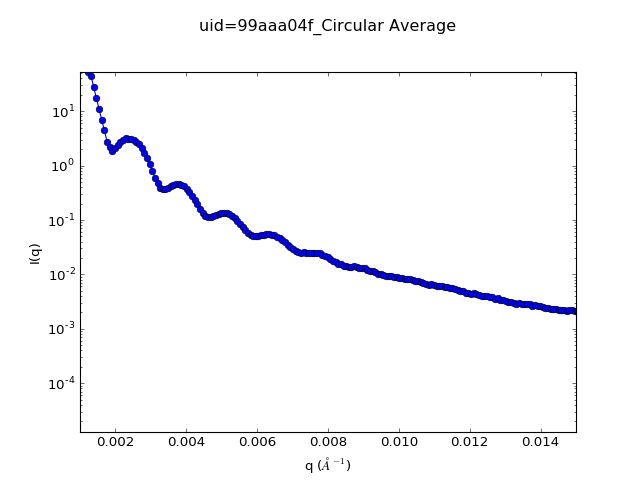

In [34]:
if scat_geometry =='saxs' or 'ang_saxs':
    ## Get circular average| * Do plot and save q~iq
    hmask = create_hot_pixel_mask( avg_img, threshold = 100, center= center, center_radius= 400)
    qp_saxs, iq_saxs, q_saxs = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs  )

    xlim= [ 0.001, 0.015] #None
    
    plot_circular_average( qp_saxs, iq_saxs, q_saxs,  pargs=setup_pargs, xlim= xlim )    
    pd = trans_data_to_pd( np.where( hmask !=1), 
            label=[md['uid']+'_hmask'+'x', md['uid']+'_hmask'+'y' ], dtype='list')
    pd.to_csv('/XF11ID/analysis/Commissioning/eiger4M_badpixel.csv', mode='a'  )
    mask =np.array( mask * hmask, dtype=bool) 
    #show_img( mask )

In [35]:
if scat_geometry   =='saxs' or 'ang_saxs':
    if run_fit_form:        
        form_res = fit_form_factor( q_saxs,iq_saxs,  guess_values={'radius': 2500, 'sigma':0.05, 
         'delta_rho':1E-10 },  fit_range=[0.0001, 0.015], fit_variables={'radius': T, 'sigma':T, 
         'delta_rho':T},  res_pargs=setup_pargs, xlim=[0.0001, 0.015])  

In [36]:
if scat_geometry  =='saxs' or 'ang_saxs':
    uniformq = True #False    #True #False    
    ## Define ROI
    #* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
    #* Create ring mask defined by  edges (all in pixel unit)    
    ### Define a non-uniform distributed rings by giving edges
    if not uniformq:    
        width = 0.0002    
        number_rings= 1    
        qcenters = [ 0.00235,0.00379,0.00508,0.00636,0.00773, 0.00902] #in A-1
        edges = get_non_uniform_edges(  qcenters, width, number_rings )    
        inner_radius= None
        outer_radius = None
        width = None
        num_rings = None        
    # Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)
    if uniformq:  
        inner_radius= 0.002  # 0.005 #0.006  #16
        outer_radius = 0.003 #0.04 #0.05  #112    
        num_rings = 5  #12
        gap_ring_number = 6
        width =   0.0002 #  ( outer_radius - inner_radius)/(num_rings + gap_ring_number)
        edges = None

<IPython.core.display.Javascript object>


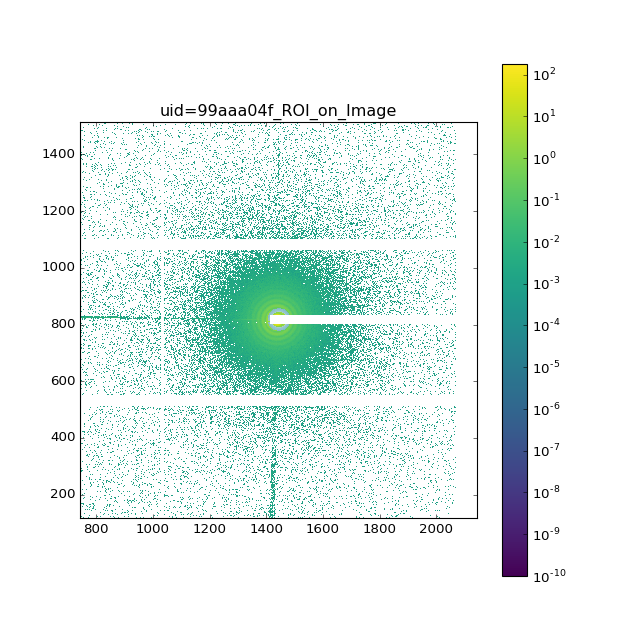

In [39]:
if scat_geometry =='saxs' or 'ang_saxs':
    roi_mask, qr, qr_edge = get_ring_mask(  mask, inner_radius=inner_radius, 
            outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges,
                          unit='A',       pargs=setup_pargs   )
    qind, pixelist = roi.extract_label_indices(  roi_mask  ) 
    qr = np.round( qr, 4)
    show_ROI_on_image( avg_img, roi_mask, center, label_on = False, rwidth =700, alpha=.9,  
                     save=True, path=data_dir, uid=uidstr, vmin= np.min(avg_img), vmax= np.max(avg_img) ) 
    qval_dict = get_qval_dict( np.round(qr, 4)  ) 

<IPython.core.display.Javascript object>


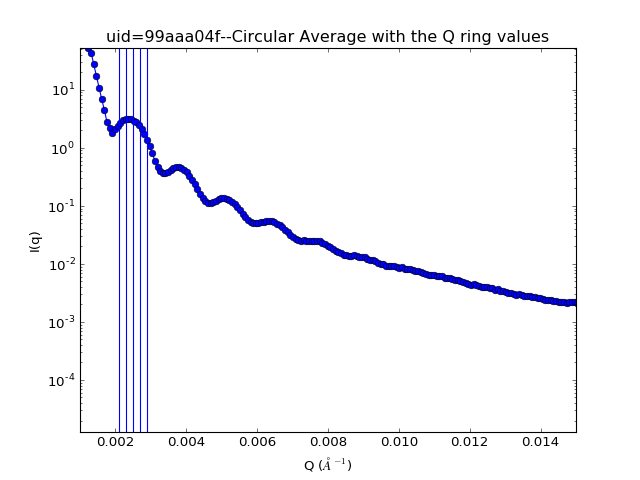

In [38]:
if scat_geometry  =='saxs' or 'ang_saxs':    
    xlim= [ 0.001, 0.015] #None    
    plot_qIq_with_ROI( q_saxs, iq_saxs, qr, logs=True, uid=uidstr, xlim=xlim,  save=True, path=data_dir)
        

## Static Analysis for saxs

In [41]:
if scat_geometry =='saxs':  
    Nimg = FD.end - FD.beg 
    time_edge = create_time_slice( N= Nimg, slice_num= 3, slice_width= 1, edges = None )
    time_edge =  np.array( time_edge ) + good_start
    print( time_edge )
    
    qpt, iqst, qt = get_t_iqc( FD, time_edge, mask, pargs=setup_pargs, nx=1500 )
    plot_t_iqc( qt, iqst, time_edge, pargs=setup_pargs, xlim=[qt.min(), qt.max()],
           ylim = [iqst.min(), iqst.max()], save=True )

# Ang_SAXS (flow) Scattering Geometry

### Create flow vertical/parallel array mask

In [52]:
if scat_geometry =='ang_saxs': 
    width_angle_v = 2
    angle_v = 132
    num_angles_v =   1 
    inner_angle_v=  angle_v -  width_angle_v
    outer_angle_v =  angle_v + width_angle_v            
    roi_mask_v, qval_dict_v =  get_seg_from_ring_mask( inner_angle_v, outer_angle_v,
                                            num_angles_v, width_angle_v, center, roi_mask, qr ) 
    
    width_angle_p = 2
    angle_p = 42
    num_angles_p =   1  
    inner_angle_p=  angle_p -  width_angle_p
    outer_angle_p =  angle_p + width_angle_p      
    roi_mask_p, qval_dict_p =  get_seg_from_ring_mask( inner_angle_p, outer_angle_p,
                                            num_angles_p, width_angle_p, center, roi_mask, qr ) 

 

    #show_ROI_on_image( avg_img, seg_mask_v, center, label_on = True, rwidth=120, alpha=.9, 
    #              vmax=30, save=True, path=data_dir, uid=uid + '_Vert_')

# GiSAXS Scattering Geometry

In [53]:
if scat_geometry =='gi_saxs':
    # Get Q-Map (Qz and Qr)
    ### Users put incident-Beam and Reflection_Beam Centers here!!!
    # Change these lines
    inc_x0 = 1572 - 3
    inc_y0 = 64

    refl_x0 = 1572 
    refl_y0 = 452
    
    # Don't Change these lines below here
    alphaf,thetaf, alphai, phi = get_reflected_angles( inc_x0, inc_y0,refl_x0 , refl_y0, Lsd=Ldet )
    qx_map, qy_map, qr_map, qz_map = convert_gisaxs_pixel_to_q( inc_x0, inc_y0,refl_x0,refl_y0, lamda=lambda_, Lsd=Ldet )
    ticks_  = get_qzr_map(  qr_map, qz_map, inc_x0, Nzline=10,  Nrline=10   )
    ticks = ticks_[:4]
    plot_qzr_map(  qr_map, qz_map, inc_x0, ticks = ticks_, data= avg_img, uid= uidstr, path = data_dir   )

## Static Analysis for gisaxs

In [54]:
if scat_geometry =='gi_saxs':
    # For diffuse near Yoneda wing
    qz_start = 0.034
    qz_end = 0.039
    qz_num= 1
    qz_width = 0.005

    qr_start =  0.002
    qr_end = 0.08
    qr_num = 1
    qr_width = 0.08 - 0.002


    Qr = [qr_start , qr_end, qr_width, qr_num]
    Qz=  [qz_start,   qz_end,  qz_width , qz_num ]

    # Don't Change these lines below here
    roi_mask, qval_dict = get_gisaxs_roi( Qr, Qz, qr_map, qz_map, mask= mask )

    show_qzr_roi( avg_img, roi_mask, inc_x0, ticks, alpha=0.5, save=True, path=data_dir, uid=uidstr )

In [55]:
if  scat_geometry =='gi_saxs':
    Nimg = FD.end - FD.beg 
    time_edge = create_time_slice( N= Nimg, slice_num= 10, slice_width= 2, edges = None )
    time_edge =  np.array( time_edge ) + good_start
    print( time_edge )    
    qrt_pds = get_t_qrc( FD, time_edge, Qr, Qz, qr_map, qz_map, path=data_dir, uid = uidstr )    
    plot_qrt_pds( qrt_pds, time_edge, qz_index = 0, uid = uidstr, path =  data_dir )

# Make a Profile Plot

In [56]:
if  scat_geometry =='gi_saxs':
    #img_index = 0
    #show_img(  imgs[img_index] +1, xlim = [1330,1810], ylim=[2167-2150, 2167-1200],  vmin=1, vmax=50, logs=True,
    #    image_name= uidstr + '_frame_%s'%img_index)
    
    
    xcorners= [ 1330, 1810, 1810, 1330 ]
    ycorners= [ 312, 312, 362, 362 ]
    waterfall_roi_size = [ xcorners[1] - xcorners[0],  ycorners[2] - ycorners[1]  ]
    waterfall_roi =  create_rectangle_mask(  avg_img, xcorners, ycorners   )
    #show_img( waterful_roi * avg_img, xlim = [1330,1810], ylim=[212, 462], aspect=1,vmin=1, vmax=50, logs=True, )
    
    wat = cal_waterfallc( FD, waterfall_roi, qindex= 1, bin_waterfall=True,
                          waterfall_roi_size = waterfall_roi_size,save =True, path=data_dir, uid=uidstr)
    

In [57]:
if  scat_geometry =='gi_saxs':
    plot_waterfallc( wat_spec, qindex=1, aspect=None, vmin=1, vmax= np.max( wat_spec), uid=uidstr, save =True, 
                        path=data_dir, beg= FD.beg)

## Dynamic Analysis for gi_saxs

In [58]:
if scat_geometry =='gi_saxs':
    # Define Q-ROI
    #* Users provide the interested Qz and Qr here for XPCS analysis, e.g., qr start/end/number/width et.al
    # Change these lines

    qz_start = 0.037
    qz_end = 0.065 + 0.002 #0.050 + 0.0015
    qz_num= 3
    gap_qz_num = 1    
    qz_width =  0.002 #(qz_end - qz_start)/(qz_num +gap_qz_num)
    
    qr_start =   0.008
    qr_end = 0.048 + 0.008
    qr_num = 16
    gap_qr_num = 5
    qr_width = 0.003 #( qr_end- qr_start)/(qr_num+gap_qr_num)

    Qr = [qr_start , qr_end, qr_width, qr_num]
    Qz=  [qz_start,   qz_end,  qz_width , qz_num ]
    # Don't Change these lines below here
    roi_mask, qval_dict = get_gisaxs_roi( Qr, Qz, qr_map, qz_map, mask= mask )



In [59]:
if scat_geometry =='gi_saxs':
    ### Change the below lines to if define another ROI, if define even more, just repeat this process
    define_second_roi = True #False  #if True to define another line; else: make it False
    if define_second_roi:    
        qval_dict1 = qval_dict.copy()
        roi_mask1 = roi_mask.copy()
        del qval_dict, roi_mask
    ## The Second ROI
    if define_second_roi:    
        qz_start2 = 0.044
        qz_end2 = 0.05
        qz_num2= 1
        gap_qz_num2 = 1
        qz_width2 = 0.005 #(qz_end2 - qz_start2)/(qz_num2 +gap_qz_num2)    
        
        qr_start2 =  -0.003
        qr_end2 = 0.003
        qr_num2 = 1
        gap_qr_num2 = 5
        qr_width2 = 0.006 #( qr_end2- qr_start2)/(qr_num2+gap_qr_num2)        
        
        Qr2 = [qr_start2 , qr_end2, qr_width2, qr_num2]
        Qz2=  [qz_start2,   qz_end2,  qz_width2 , qz_num2 ] 
        roi_mask2, qval_dict2 = get_gisaxs_roi( Qr2, Qz2, qr_map, qz_map, mask= mask )
        qval_dict = update_qval_dict(  qval_dict1, qval_dict2 )
        roi_mask = update_roi_mask(  roi_mask1, roi_mask2 )        
        show_qzr_roi( avg_img, roi_mask, inc_x0, ticks, alpha=0.5, save=True, path=data_dir, uid=uidstr )        
        ## Get 1D Curve (Q||-intensity¶)
        qr_1d_pds = cal_1d_qr( avg_img, Qr, Qz, qr_map, qz_map, inc_x0= None, setup_pargs=setup_pargs )
        plot_qr_1d_with_ROI( qr_1d_pds, qr_center=np.unique( np.array(list( qval_dict.values() ) )[:,0] ),
                    loglog=False, save=True, uid=uidstr, path = data_dir)

* Extract the labeled array

In [60]:
qind, pixelist = roi.extract_label_indices(roi_mask)
noqs = len(np.unique(qind))

* Number of pixels in each q box

In [61]:
nopr = np.bincount(qind, minlength=(noqs+1))[1:]
nopr

array([292, 341, 453, 516, 551])

## Check one ROI intensity

In [62]:
if scat_geometry !='ang_saxs':
    roi_inten = check_ROI_intensity( avg_img, roi_mask, ring_number= qth_interest, uid =uidstr, save=True, path=data_dir )

## Do a waterfall analysis

In [63]:
if scat_geometry =='saxs':
    if run_waterfall:    
        wat = cal_waterfallc( FD, roi_mask, qindex= qth_interest, save =True, path=data_dir, uid=uidstr)

In [64]:
if scat_geometry =='saxs':
    if run_waterfall: 
        plot_waterfallc( wat, qth_interest, aspect=None, 
                        vmax= np.max(wat), uid=uidstr, save =True, 
                        path=data_dir, beg= FD.beg)

In [65]:
ring_avg = None    
if run_t_ROI_Inten:
    times_roi, mean_int_sets = cal_each_ring_mean_intensityc(FD, roi_mask, timeperframe = None,  ) 
    plot_each_ring_mean_intensityc( times_roi, mean_int_sets,  uid = uidstr, save=True, path=data_dir )
    roi_avg = np.average( mean_int_sets, axis=0)
    

## One time Correlation

Note : Enter the number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/correlation.py

### if define another good_series

In [66]:
define_good_series = False
if define_good_series:
    FD = Multifile(filename, beg = good_start, end = Nimg)
    uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
    print( uid_ )

In [67]:
lag_steps = None
if use_sqnorm:
    norm = get_pixelist_interp_iq( qp_saxs, iq_saxs, roi_mask, center)
else:
    norm=None 
if use_imgsum_norm:
    imgsum_ = imgsum
else:
    imgsum_ = None     

In [68]:
if run_one_time: 
    t0 = time.time() 
    if scat_geometry !='ang_saxs':  
        g2, lag_steps  = cal_g2p( FD,  roi_mask, bad_frame_list,good_start, num_buf = 8, num_lev= None,
                            imgsum= imgsum_, norm=norm )
    else:
        g2_v, lag_steps_v  = cal_g2p( FD,  roi_mask_v, bad_frame_list,good_start, num_buf = 8, num_lev= None,
                            imgsum= imgsum_, norm=norm )  
        g2_p, lag_steps_p  = cal_g2p( FD,  roi_mask_p, bad_frame_list,good_start, num_buf = 8, num_lev= None,
                            imgsum= imgsum_, norm=norm )  
        
    run_time(t0)
    

In this g2 calculation, the buf and lev number are: 8--9--
Bad frame involved and will be precessed!
957 frames will be processed...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 5/5 [00:01<00:00,  4.94it/s]


G2 calculation DONE!
In this g2 calculation, the buf and lev number are: 8--9--
Bad frame involved and will be precessed!
957 frames will be processed...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 5/5 [00:01<00:00,  4.11it/s]

G2 calculation DONE!
Total time: 0.10 min


In [69]:
if run_one_time:
    if scat_geometry !='ang_saxs':  
        taus = lag_steps * timeperframe    
        g2_pds = save_g2_general( g2, taus=taus,qr=np.array( list( qval_dict.values() ) )[:,0],
                             uid=uid_+'_g2.csv', path= data_dir, return_res=True )
    else:
        taus_v = lag_steps_v * timeperframe    
        g2_pds_v = save_g2_general( g2_v, taus=taus_v,qr=np.array( list( qval_dict_v.values() ) )[:,0],
                             uid=uid_+'_g2v.csv', path= data_dir, return_res=True )        

        taus_p = lag_steps_p * timeperframe    
        g2_pds_p = save_g2_general( g2_p, taus=taus_p,qr=np.array( list( qval_dict_p.values() ) )[:,0],
                             uid=uid_+'_g2p.csv', path= data_dir, return_res=True )    

The correlation function is saved in /XF11ID/analysis/2016_3/yuzhang/Results/99aaa04f/ with filename as uid=99aaa04f_fra_42_1000_g2v.csv
The correlation function is saved in /XF11ID/analysis/2016_3/yuzhang/Results/99aaa04f/ with filename as uid=99aaa04f_fra_42_1000_g2p.csv


### Plot the one time correlation functions

In [71]:
#if run_one_time:
#    plot_g2_general( g2_dict={1:g2}, taus_dict={1:taus},vlim=[0.95, 1.05], qval_dict = qval_dict, fit_res= None, 
#                geometry=scat_geometry,filename=uid_+'_g2',path= data_dir,   ylabel='g2')

# Fit g2

In [72]:
if run_one_time:
    if scat_geometry !='ang_saxs':  
        g2_fit_result, taus_fit, g2_fit = get_g2_fit_general( g2,  taus, 
                function = fit_g2_func,  vlim=[0.95, 1.05], fit_range= None,  
            fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},                                  
            guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,}) 
        g2_fit_paras = save_g2_fit_para_tocsv(g2_fit_result,  filename= uid_  +'_g2_fit_paras.csv', path=data_dir ) 
        
    else:#for flow fit        
        fit_g2_func_v = 'stretched' #for vertical
        g2_fit_result_v, taus_fit_v, g2_fit_v = get_g2_fit_general( g2_v,  taus_v, 
                function = fit_g2_func_v,  vlim=[0.95, 1.05], fit_range= None,  
            fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},                                  
            guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,}) 
        g2_fit_paras_v = save_g2_fit_para_tocsv(g2_fit_result_v,  filename= uid_  +'_g2_fit_paras_v.csv', path=data_dir ) 
                
        fit_g2_func_p ='flow_para' #for parallel
        g2_fit_result_p, taus_fit_p, g2_fit_p = get_g2_fit_general( g2_p,  taus_p, 
                function = fit_g2_func_p,  vlim=[0.95, 1.05], fit_range= None,  
            fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True,'flow_velocity':True},                                  
            guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,'flow_velocity':1}) 
        g2_fit_paras_p = save_g2_fit_para_tocsv(g2_fit_result_p,  filename= uid_  +'_g2_fit_paras_p.csv', path=data_dir ) 
                
        

The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/yuzhang/Results/99aaa04f/uid=99aaa04f_fra_42_1000_g2_fit_paras_v.csv
The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/yuzhang/Results/99aaa04f/uid=99aaa04f_fra_42_1000_g2_fit_paras_p.csv


<IPython.core.display.Javascript object>


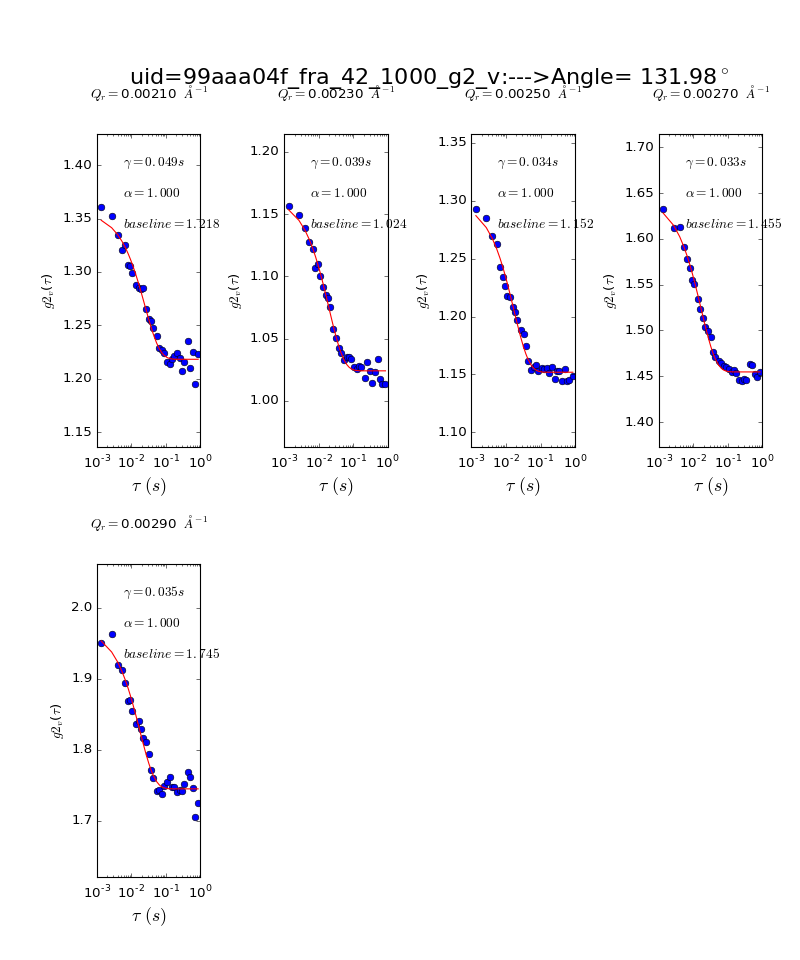

<IPython.core.display.Javascript object>


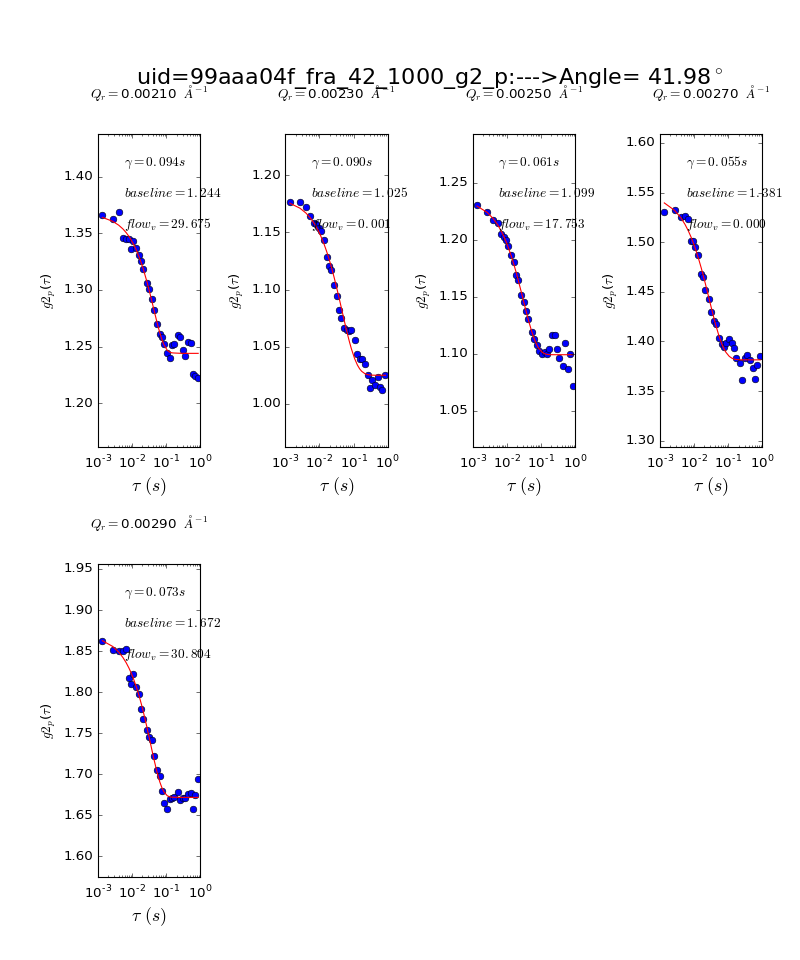

The combined image is saved as: /XF11ID/analysis/2016_3/yuzhang/Results/99aaa04f/uid=99aaa04f_fra_42_1000_g2_fit.png


In [73]:
if run_one_time:
    if scat_geometry !='ang_saxs':      
        plot_g2_general( g2_dict={1:g2, 2:g2_fit}, taus_dict={1:taus, 2:taus_fit},vlim=[0.95, 1.05],
                qval_dict = qval_dict, fit_res= g2_fit_result,  geometry=scat_geometry,filename= uid_+'_g2', 
                    path= data_dir, function= fit_g2_func,  ylabel='g2', append_name=  '_fit')
    else:
        plot_g2_general( g2_dict={1:g2_v, 2:g2_fit_v}, taus_dict={1:taus_v, 2:taus_fit_v},vlim=[0.95, 1.05],
                qval_dict = qval_dict_v, fit_res= g2_fit_result_v,  geometry=scat_geometry,filename= uid_+'_g2_v', 
                    path= data_dir, function= fit_g2_func_v,  ylabel='g2_v', append_name=  '_fit')        
        
        plot_g2_general( g2_dict={1:g2_p, 2:g2_fit_p}, taus_dict={1:taus_p, 2:taus_fit_p},vlim=[0.95, 1.05],
                qval_dict = qval_dict_p, fit_res= g2_fit_result_p,  geometry=scat_geometry,filename= uid_+'_g2_p', 
                    path= data_dir, function= fit_g2_func_p,  ylabel='g2_p', append_name=  '_fit')   
        
        combine_images( [data_dir + uid_+'_g2_v_fit.png', data_dir + uid_+'_g2_p_fit.png'], data_dir + uid_+'_g2_fit.png', outsize=(2000, 2400) )

The fitted diffusion coefficient D0 is:  4.133e+06   A^2S-1


<IPython.core.display.Javascript object>


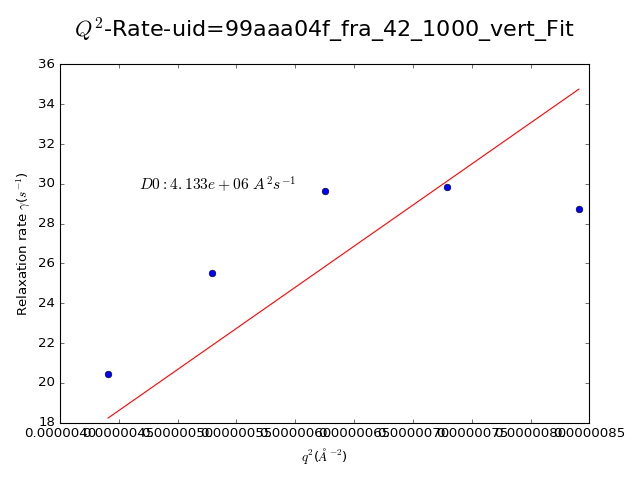

The fitted diffusion coefficient D0 is:  2.163e+06   A^2S-1


<IPython.core.display.Javascript object>


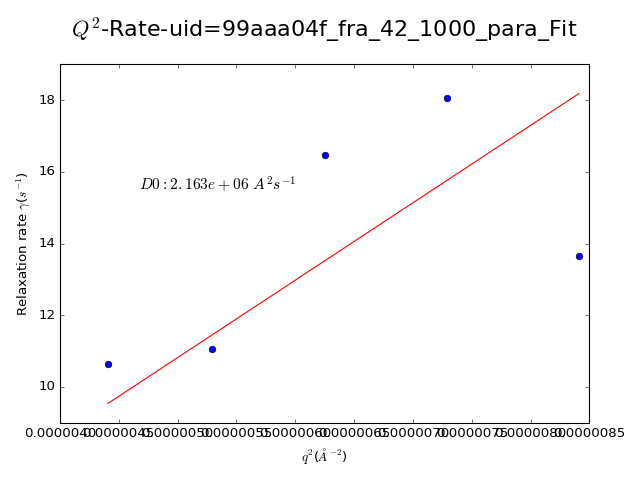

The combined image is saved as: /XF11ID/analysis/2016_3/yuzhang/Results/99aaa04f/uid=99aaa04f_fra_42_1000_Q_Rate_fit.png


In [79]:
if run_one_time:
    if scat_geometry !='ang_saxs':     
        D0, qrate_fit_res = get_q_rate_fit_general(  qval_dict, g2_fit_paras['relaxation_rate'], geometry= scat_geometry )
        plot_q_rate_fit_general( qval_dict, g2_fit_paras['relaxation_rate'],  qrate_fit_res, 
                            geometry= scat_geometry,uid=uid_  , path= data_dir )
    else:
        D0_v, qrate_fit_res_v = get_q_rate_fit_general(  qval_dict_v, g2_fit_paras_v['relaxation_rate'], geometry= scat_geometry )
        plot_q_rate_fit_general( qval_dict_v, g2_fit_paras_v['relaxation_rate'],  qrate_fit_res_v, 
                            geometry= scat_geometry,uid=uid_ +'_vert' , path= data_dir )
        
        D0_p, qrate_fit_res_p = get_q_rate_fit_general(  qval_dict_p, g2_fit_paras_p['relaxation_rate'], geometry= scat_geometry )
        plot_q_rate_fit_general( qval_dict_p, g2_fit_paras_p['relaxation_rate'],  qrate_fit_res_p, 
                            geometry= scat_geometry,uid=uid_ +'_para' , path= data_dir )
        
        
        combine_images( [data_dir + uid_+ '_vert_Q_Rate_fit.png', data_dir + uid_+ '_para_Q_Rate_fit.png'], data_dir + uid_+'_Q_Rate_fit.png', outsize=(2000, 2400) )

# For two-time

In [80]:
data_pixel = None
if run_two_time:    
    data_pixel =   Get_Pixel_Arrayc( FD, pixelist,  norm= norm ).get_data()

In [81]:
t0=time.time()
g12b=None
if run_two_time:     
    g12b = auto_two_Arrayc(  data_pixel,  roi_mask, index = None   )
run_time( t0 )        

Total time: 0.00 min


In [82]:
if run_two_time:
    show_C12(g12b, q_ind= qth_interest, N1= FD.beg, N2=min( FD.end,5000), vmin=1.0, vmax=1.18,
             timeperframe=timeperframe,save=True, path= data_dir, uid = uid )    

In [83]:
if run_two_time:
    if lag_steps is None:
        num_bufs=8
        noframes = FD.end - FD.beg
        num_levels = int(np.log( noframes/(num_bufs-1))/np.log(2) +1) +1
        tot_channels, lag_steps, dict_lag = multi_tau_lags(num_levels, num_bufs)
        max_taus= lag_steps.max()
        
    #max_taus= lag_steps.max()  
    max_taus = Nimg    
    t0=time.time()
    g2b = get_one_time_from_two_time(g12b)[:max_taus]
    run_time(t0)
    tausb = np.arange( g2b.shape[0])[:max_taus] *timeperframe     
    g2b_pds = save_g2_general( g2b, taus=tausb, qr= np.array( list( qval_dict.values() ) )[:,0],
                              qz=None, uid=uid_ +'_g2b.csv', path= data_dir, return_res=True )
    

In [84]:
if run_two_time:
    g2_fit_resultb, taus_fitb, g2_fitb = get_g2_fit_general( g2b,  tausb, 
                function = fit_g2_func,  vlim=[0.95, 1.05], fit_range= None,  
                fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},                                  
                guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,}) 
    
    g2b_fit_paras = save_g2_fit_para_tocsv(g2_fit_resultb, 
                    filename= '%s'%uid_  + '_g2b_fit_paras.csv', path=data_dir )

In [85]:
if run_two_time:
    plot_g2_general( g2_dict={1:g2b, 2:g2_fitb}, taus_dict={1:tausb, 2:taus_fitb},vlim=[0.95, 1.05],
                qval_dict=qval_dict, fit_res= g2_fit_resultb,  geometry=scat_geometry,filename=uid_+'_g2', 
                    path= data_dir, function= fit_g2_func,  ylabel='g2', append_name=  '_b_fit')

In [86]:
if run_two_time and run_one_time:
    plot_g2_general( g2_dict={1:g2, 2:g2b}, taus_dict={1:taus, 2:tausb},vlim=[0.95, 1.05],
                qval_dict=qval_dict, g2_labels=['from_one_time', 'from_two_time'],
            geometry=scat_geometry,filename=uid_+'_g2_two_g2', path= data_dir, ylabel='g2', )

# Four Time Correlation

In [87]:
if run_four_time:
    t0=time.time()
    g4 = get_four_time_from_two_time(g12b, g2=g2b)[:max_taus]
    run_time(t0)

In [88]:
if run_four_time:
    taus4 = np.arange( g4.shape[0])*timeperframe        
    g4_pds = save_g2_general( g4, taus=taus4, qr=np.array( list( qval_dict.values() ) )[:,0],
                             qz=None, uid=uid_ +'_g4.csv', path= data_dir, return_res=True )
     


In [89]:
if run_four_time:
    plot_g2_general( g2_dict={1:g4}, taus_dict={1:taus4},vlim=[0.95, 1.05], qval_dict=qval_dict, fit_res= None, 
                geometry=scat_geometry,filename=uid_+'_g4',path= data_dir,   ylabel='g4')

# Speckel Visiblity

In [90]:
if run_xsvs:    
    max_cts = get_max_countc(FD, roi_mask )
    qind, pixelist = roi.extract_label_indices(   roi_mask  )
    noqs = len( np.unique(qind) )
    nopr = np.bincount(qind, minlength=(noqs+1))[1:]
    #time_steps = np.array( utils.geometric_series(2,   len(imgs)   ) )
    time_steps = [0,1]  #only run the first two levels
    num_times = len(time_steps)    
    times_xsvs = exposuretime + (2**(  np.arange( len(time_steps) ) ) -1 ) * acquisition_period    
    print( 'The max counts are: %s'%max_cts )


### Do historam 

In [91]:
if run_xsvs:
    if roi_avg is  None:
        times_roi, mean_int_sets = cal_each_ring_mean_intensityc(FD, roi_mask, timeperframe = None,  ) 
        roi_avg = np.average( mean_int_sets, axis=0)
    
    t0=time.time()
    spec_bins, spec_his, spec_std  =  xsvsp( FD, np.int_(roi_mask), norm=None,
                max_cts=int(max_cts+2),  bad_images=bad_frame_list, only_two_levels=True )    
    spec_kmean =  np.array(  [roi_avg * 2**j for j in  range( spec_his.shape[0] )] )
    run_time(t0)
    spec_pds =  save_bin_his_std( spec_bins, spec_his, spec_std, filename=uid_+'_spec_res.csv', path=data_dir ) 

### Do historam fit by negtive binominal function with maximum likehood method

In [92]:
if run_xsvs:    
    ML_val, KL_val,K_ = get_xsvs_fit(  spec_his, spec_kmean,  spec_std, max_bins=2,varyK= False, )
    #print( 'The observed average photon counts are: %s'%np.round(K_mean,4))
    #print( 'The fitted average photon counts are: %s'%np.round(K_,4)) 
    print( 'The difference sum of average photon counts between fit and data are: %s'%np.round( 
            abs(np.sum( spec_kmean[0,:] - K_ )),4))
    print( '#'*30)
    qth=   10 
    print( 'The fitted M for Qth= %s are: %s'%(qth, ML_val[qth]) )
    print( K_[qth])
    print( '#'*30)

## Plot fit results

In [93]:
if run_xsvs:   
    plot_xsvs_fit(  spec_his, ML_val, KL_val, K_mean = spec_kmean, spec_std=spec_std,
                  xlim = [0,10], vlim =[.9, 1.1],
        uid=uid_, qth= qth_interest, logy= True, times= times_xsvs, q_ring_center=qr, path=data_dir)
    
    plot_xsvs_fit(  spec_his, ML_val, KL_val, K_mean = spec_kmean, spec_std = spec_std,
                  xlim = [0,15], vlim =[.9, 1.1],
        uid=uid_, qth= None, logy= True, times= times_xsvs, q_ring_center=qr, path=data_dir )

### Get contrast

In [94]:
if run_xsvs:
    contrast_factorL = get_contrast( ML_val)
    spec_km_pds = save_KM(  spec_kmean, KL_val, ML_val, qs=qr, level_time=times_xsvs, uid=uid_, path = data_dir )
    #spec_km_pds

### Plot contrast with g2 restuls

In [95]:
if run_xsvs:    
    plot_g2_contrast( contrast_factorL, g2, times_xsvs, taus, qr, 
                     vlim=[0.8,1.2], qth = qth_interest, uid=uid_,path = data_dir, legend_size=14)

    plot_g2_contrast( contrast_factorL, g2, times_xsvs, taus, qr, 
                     vlim=[0.8,1.2], qth = None, uid=uid_,path = data_dir, legend_size=4)

# Export Results to a HDF5 File

In [96]:
md['mask_file']= mask_path + mask_name
md['mask'] = mask
md['NOTEBOOK_FULL_PATH'] = None
md['good_start'] = good_start
md['bad_frame_list'] = bad_frame_list
md['avg_img'] = avg_img
md['roi_mask'] = roi_mask

if scat_geometry == 'gi_saxs':        
    md['Qr'] = Qr
    md['Qz'] = Qz
    md['qval_dict'] = qval_dict
    md['beam_center_x'] =  inc_x0
    md['beam_center_y']=   inc_y0
    md['beam_refl_center_x'] = refl_x0
    md['beam_refl_center_y'] = refl_y0

elif  scat_geometry == 'saxs':
    md['qr']= qr
    md['qr_edge'] = qr_edge
    md['qval_dict'] = qval_dict
    md['beam_center_x'] =  center[1]
    md['beam_center_y']=  center[0]  
    
elif  scat_geometry == 'ang_saxs':
    md['qval_dict_v'] = qval_dict_v
    md['qval_dict_p'] = qval_dict_p
    md['beam_center_x'] =  center[1]
    md['beam_center_y']=  center[0]     

md['beg'] = FD.beg
md['end'] = FD.end
md['metadata_file'] = data_dir + 'md.csv-&-md.pkl'
psave_obj(  md, data_dir + 'uid=%s_md'%uid ) #save the setup parameters
save_dict_csv( md,  data_dir + 'uid=%s_md.csv'%uid, 'w')

Exdt = {} 
if scat_geometry == 'gi_saxs':  
    for k,v in zip( ['md', 'q_saxs', 'iq_saxs', 'roi_mask','roi_mask_p','roi_mask_v','qval_dict','avg_img','mask','pixel_mask', 'imgsum', 'bad_frame_list', 'qr_1d_pds'], 
                [md,  q_saxs, iq_saxs,roi_mask,roi_mask_p,roi_mask_v, qval_dict, avg_img,mask,pixel_mask, imgsum, bad_frame_list, qr_1d_pds] ):
        Exdt[ k ] = v
elif scat_geometry == 'saxs': 
    for k,v in zip( ['md', 'q_saxs', 'iq_saxs','iqst','qt','roi_mask','qval_dict','avg_img','mask','pixel_mask', 'imgsum', 'bad_frame_list'], 
                [md, q_saxs, iq_saxs, iqst, qt,roi_mask, qval_dict, avg_img,mask,pixel_mask, imgsum, bad_frame_list] ):
        Exdt[ k ] = v
elif scat_geometry == 'ang_saxs':     
    for k,v in zip( ['md', 'q_saxs', 'iq_saxs','roi_mask_v','roi_mask_p',
                     'qval_dict_v','qval_dict_p','avg_img','mask','pixel_mask', 'imgsum', 'bad_frame_list'], 
               [md, q_saxs, iq_saxs, roi_mask_v,roi_mask_p,
                qval_dict_v,qval_dict_p, avg_img,mask,pixel_mask, imgsum, bad_frame_list] ):
        Exdt[ k ] = v  

if run_waterfall:Exdt['wat'] =  wat
if run_t_ROI_Inten:Exdt['times_roi'] = times_roi;Exdt['mean_int_sets']=mean_int_sets
if run_one_time:
    if scat_geometry != 'ang_saxs':         
        for k,v in zip( ['taus','g2','g2_fit_paras'], [taus,g2,g2_fit_paras] ):Exdt[ k ] = v
    else:
        for k,v in zip( ['taus_v','g2_v','g2_fit_paras_v'], [taus_v,g2_v,g2_fit_paras_v] ):Exdt[ k ] = v
        for k,v in zip( ['taus_p','g2_p','g2_fit_paras_p'], [taus_p,g2_p,g2_fit_paras_p] ):Exdt[ k ] = v
if run_two_time:
    for k,v in zip( ['tausb','g2b','g2b_fit_paras', 'g12b'], [tausb,g2b,g2b_fit_paras,g12b] ):Exdt[ k ] = v
if run_four_time:
    for k,v in zip( ['taus4','g4'], [taus4,g4] ):Exdt[ k ] = v
if run_xsvs:
    for k,v in zip( ['spec_kmean','spec_pds','times_xsvs','spec_km_pds','contrast_factorL'], 
                   [ spec_kmean,spec_pds,times_xsvs,spec_km_pds,contrast_factorL] ):Exdt[ k ] = v 

In [104]:
export_xpcs_results_to_h5( 'uid=%s_Res.h5'%md['uid'], data_dir, export_dict = Exdt )
#extract_dict = extract_xpcs_results_from_h5( filename = 'uid=%s_Res.h5'%md['uid'], import_dir = data_dir )

The xpcs analysis results are exported to /XF11ID/analysis/2016_3/yuzhang/Results/99aaa04f/ with filename as uid=99aaa04f-a6af-4ca0-9e5b-1c9e2704d6be_Res.h5


# Creat PDF Report

In [98]:
pdf_out_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
pdf_filename = "XPCS_Analysis_Report_for_uid=%s%s.pdf"%(uid,pdf_version)
if run_xsvs:
    pdf_filename = "XPCS_XSVS_Analysis_Report_for_uid=%s%s.pdf"%(uid,pdf_version)

In [99]:
make_pdf_report( data_dir, uid, pdf_out_dir, pdf_filename, username, 
                    run_fit_form,run_one_time, run_two_time, run_four_time, run_xsvs, report_type= scat_geometry
                   )


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/yuzhang/Results/XPCS_Analysis_Report_for_uid=99aaa04f_1.pdf
****************************************


## Attach the PDF report to Olog 

In [100]:
if att_pdf_report:     
    os.environ['HTTPS_PROXY'] = 'https://proxy:8888'
    os.environ['no_proxy'] = 'cs.nsls2.local,localhost,127.0.0.1'
    pname = pdf_out_dir + pdf_filename 
    atch=[  Attachment(open(pname, 'rb')) ] 
    try:
        update_olog_uid( uid= md['uid'], text='Add XPCS Analysis PDF Report', attachments= atch )
    except:
        print("I can't attach this PDF: %s due to a duplicated filename. Please give a different PDF file."%pname)

The url=https://logbook.nsls2.bnl.gov/Olog-11-ID/Olog was successfully updated with Add XPCS Analysis PDF Report and with the attachments


# The End!